## Notes on analytic questions

### 1. What types of agencies are in the customer pipeline and what are their needs and interests?
- Summarize # agencies, # contacts, summary stats on # contacts per agency
- Total by type of agency (local PD, county sheriff, state PD, DA's office, etc.)
- Total n opportunities by stage (prospecting, quote, closing)
- Revenue by product type (license, training, support, etc.)
- Customer needs by product (training but no license, license but no training, etc.)

### 2. How quickly do customers move through the sales pipeline, and how is the sales process affected by attendance at presentations and training campaigns?
- Excluding sales opportunities managed by the reseller, within the subset of software final training sales that have a closing date, how much time elapses between the initial prospecting conversation and first quote (summary stats)? How much time elapses between first quote and final sale (summary stats)? By type of product? 
- Total n attending training/presentation campaigns by campaign type
- Of agencies attending training campaigns and presentations, how many also purchase software/final training, and how long after the campaign do they move forward in the sales pipeline? By type of agency?

### 3. How do the demographics of the customer agencies affect their purchasing behavior?
- What are the demographics of the contact agencies in the contact list, in terms of agency type, agency size (personnel, population of juristidiction), and expenditures?
- What is the relationship between these demographic factors and: (i) stage in the sales pipeline (final sale or not, test with chi-square for agency type, and logistic regression for agency size and budget, etc.), (ii) pace through the pipeline (ANOVA for agency type, linear regression for other factors), and (iii) amount of purchase or prospective purchase (linear regression, multiple regression)?


In [1]:
#preamble
import numpy as np
import pylab
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
%matplotlib inline
import time
import datetime
from datetime import date


In [94]:
campaigns = pd.read_csv('campaigns.csv')
contacts = pd.read_csv('contacts.csv')
opportunities = pd.read_csv('opportunities.csv')
bjs = pd.read_csv('bjs_data.csv', na_values=['#NULL!'])

## 1. Needs and Interests of Customers in the Pipeline
### a. *Characteristics of agencies in the customer base*

In [106]:
#Code date variables and create a new variable to remove future closing dates.

#strategy 1:
#for date in range(len(opportunities['Close Date'])):
#    if opportunities['Close Date'][date] == '12/31/2017':
#        opportunities['Close Date'][date] = 'NaN'

#strategy 2:
#opportunities.loc[(opportunities['Close Date'].str.contains('12/31/2017')), ['Close Date']] = 'NaN'

#strategy 3:
#opportunities['Past Close'] = opportunities['Close Date'].apply(lambda x: np.nan if x > '09/08/2017' else x)

today = datetime.date.today()
today = pd.to_datetime(today)

opportunities['Created Date'] = pd.to_datetime(opportunities['Created Date'])
opportunities['Close Date'] = pd.to_datetime(opportunities['Close Date'])
opportunities['Past Close'] = opportunities['Close Date'].apply(lambda x: np.nan if x > today else x)
opportunities['Past Close'] = pd.to_datetime(opportunities['Past Close'])

#Create a new timedelta variable to track how many days elapse between the opportunity's creation and closing.
#Map any null or negative values to NaN.

opportunities['Difference'] = opportunities['Past Close'] - opportunities['Created Date']
opportunities['Difference'] = opportunities['Difference'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
opportunities['Difference'] = opportunities['Difference'].apply(lambda x: np.nan if x<0 else x)

In [107]:
#Create a variable to categorize the types of agencies in the contacts list.
contacts['type'] = 'other'
contacts.loc[(contacts['Agency Name'].str.contains('Military')), ['type']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('Air Force')), ['type']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('Armed Forces')), ['type']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('Army')), ['type']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('Navy')), ['type']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('Police Department')), ['type']] = 'police'
contacts.loc[(contacts['Agency Name'].str.contains('City of')), ['type']] = 'police'
contacts.loc[(contacts['Agency Name'].str.contains('Police Service')), ['type']] = 'police'
contacts.loc[(contacts['Agency Name'].str.contains('Department of Public Safety')), ['type']] = 'public safety'
contacts.loc[(contacts['Agency Name'].str.contains('Sheriff')), ['type']] = 'sheriff'
contacts.loc[(contacts['Agency Name'].str.contains('Constabulary')), ['type']] = 'constabulary'
contacts.loc[(contacts['Agency Name'].str.contains('District Attorney')), ['type']] = 'district attorney'
contacts.loc[(contacts['Agency Name'].str.contains('LLC')), ['type']] = 'private attorney'
contacts.loc[(contacts['Agency Name'].str.contains('State Police')), ['type']] = 'state police'
contacts.loc[(contacts['Agency Name'].str.contains('State Trooper')), ['type']] = 'state police'
contacts.loc[(contacts['Agency Name'].str.contains('State Patrol')), ['type']] = 'state police'
contacts.loc[(contacts['Agency Name'].str.contains('Federal')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('National')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('United States')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('US Customs and Border Protection')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('US Department of Commerce')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('US Marshals Service')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Bureau of Alcohol, Tobacco, Firearms & Explosives')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Department of Homeland Security')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Department of Justice')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Drug Enforcement Administration')), ['type']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('FBI')), ['type']] = 'federal'

#Create a variable to categorize the jurisdictions of agencies in the contacts list.
contacts['jurisdiction'] = 'unknown'
contacts.loc[(contacts['type'].str.contains('military')), ['jurisdiction']] = 'military'
contacts.loc[(contacts['Agency Name'].str.contains('City of')), ['jurisdiction']] = 'local'
contacts.loc[(contacts['Agency Name'].str.contains('Police Department')), ['jurisdiction']] = 'local'
contacts.loc[(contacts['Agency Name'].str.contains('Police Service')), ['jurisdiction']] = 'local'
contacts.loc[(contacts['Agency Name'].str.contains('Sheriff')), ['jurisdiction']] = 'county'
contacts.loc[(contacts['Agency Name'].str.contains('County')), ['jurisdiction']] = 'county'
contacts.loc[(contacts['Agency Name'].str.contains('Constabulary')), ['jurisdiction']] = 'county'
contacts.loc[(contacts['Agency Name'].str.contains('District Attorney')), ['jurisdiction']] = 'county'
contacts.loc[(contacts['type'].str.contains('state police')), ['jurisdiction']] = 'state/provincial'
contacts.loc[(contacts['Agency Name'].str.contains('Provincial')), ['jurisdiction']] = 'state/provincial'
contacts.loc[(contacts['Agency Name'].str.contains('Federal') & contacts['Mailing Country'].str.contains('United States')), ['jurisdiction']] = 'federal (US)'
contacts.loc[(contacts['Agency Name'].str.contains('Federal') & contacts['Mailing Country'].str.contains('Canada')), ['jurisdiction']] = 'federal (Can)'
contacts.loc[(contacts['Agency Name'].str.contains('United States')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Bureau of Alcohol, Tobacco, Firearms & Explosives')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Department of Homeland Security')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Department of Justice')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('Drug Enforcement Administration')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('FBI')), ['jurisdiction']] = 'federal'
contacts.loc[(contacts['Agency Name'].str.contains('University')), ['jurisdiction']] = 'campus'
contacts.loc[(contacts['type'].str.contains('federal')), ['jurisdiction']] = 'federal'

#contacts['type'].apply(lambda x: x.astype(str).str.title())

In [108]:
agencies = contacts.drop_duplicates(subset='Agency Name', keep="first")

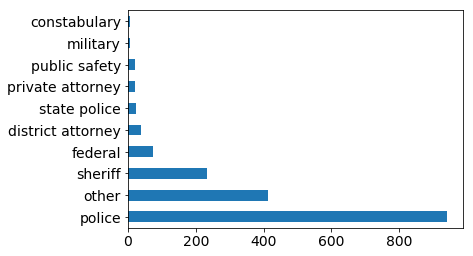

In [109]:
#Plot the frequencies of the different agency types in the customer base.
agencies['type'].value_counts().plot(kind='barh',fontsize=14)
#plt.title('Agency Types in Customer Base')
plt.show()

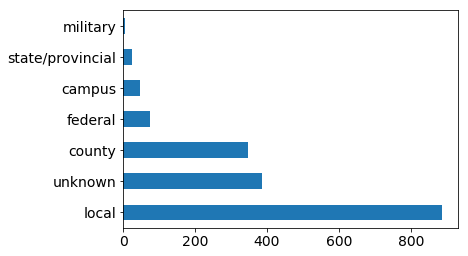

In [110]:
#Plot the frequencies of the different jurisdictions served by agencies in the customer base.

agencies['jurisdiction'].value_counts().plot(kind='barh', fontsize=14)
#plt.title('Jurisdictions Served by Customer Agencies')
plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


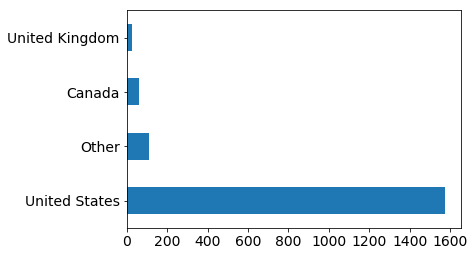

In [111]:
#Create a new variable to track the principal countries in the contacts list. 
agencies['Country'] = agencies['Mailing Country'].apply(lambda x: 'Other' if (x !='United States' and x!='Canada' and x!='United Kingdom') else x)
agencies['Country'].value_counts().plot(kind='barh', fontsize=14)
#plt.title('Jurisdictions Served by Customer Agencies')
plt.show()

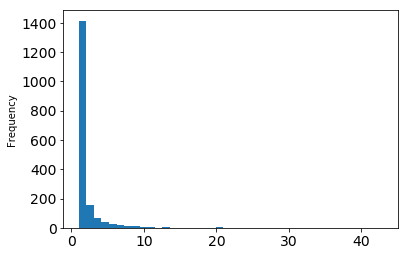

count    1772.000000
mean        2.022009
std         2.475417
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        43.000000
Name: Agency Name, dtype: float64

In [112]:
contacts_per_agency = contacts['Agency Name'].value_counts()
contacts_per_agency.plot(kind='hist', fontsize=14, bins=40)
#plt.title('Jurisdictions Served by Customer Agencies')
plt.show()
contacts_per_agency.describe()

### b. *Structure of the sales pipeline*

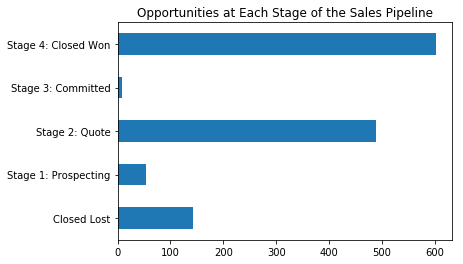

In [113]:
#Plot the frequencies of sales opportunities at different stages of the process. Change to a funnel plot.
order = ['Closed Lost', 'Stage 1: Prospecting', 'Stage 2: Quote', 'Stage 3: Committed', 'Stage 4: Closed Won']
opportunities['Stage'].value_counts().loc[order].plot.barh(stacked=True, title='Opportunities at Each Stage of the Sales Pipeline')
plt.show()

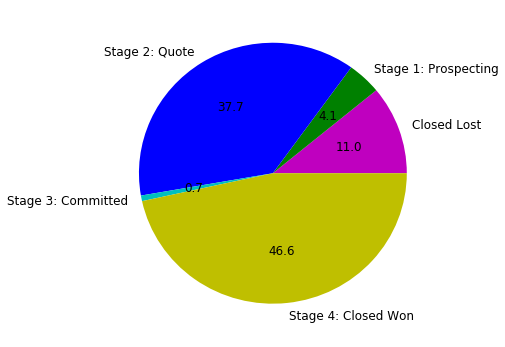

In [114]:
#working on changing the order and maybe doing a stacked bar instead
order = ['Closed Lost', 'Stage 1: Prospecting', 'Stage 2: Quote', 'Stage 3: Committed', 'Stage 4: Closed Won']
stages = opportunities['Stage'].value_counts()
opportunities['Stage'].value_counts().loc[order].plot(kind='pie', autopct='%.1f', figsize=(6, 6), colors=['m', 'g', 'b', 'c','y'], fontsize=12)
pylab.ylabel('')
#plt.title('Sales Opportunities at Each Stage of the Pipeline')

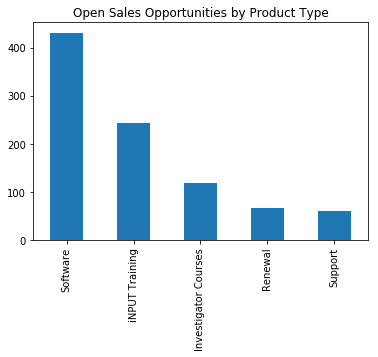

In [116]:
open_opp = opportunities[opportunities['Stage']!='Closed Lost'] 
open_opp['Product Family'].value_counts().plot(kind='bar', title='Open Sales Opportunities by Product Type')
plt.show()

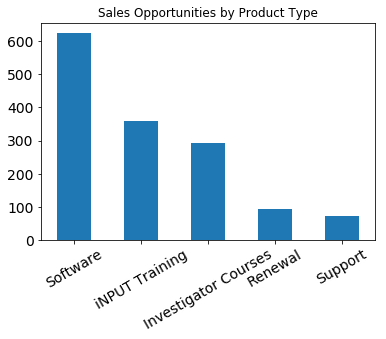

In [117]:
quant_by_type=open_opp.groupby('Product Family').sum()['Quantity'].sort_values(ascending=False) 
quant_by_type.plot.bar(fontsize=14, title='Sales Opportunities by Product Type')
plt.xticks(rotation=30)
plt.ylabel('Total Price')
plt.ylabel('')
plt.xlabel('')
plt.show()

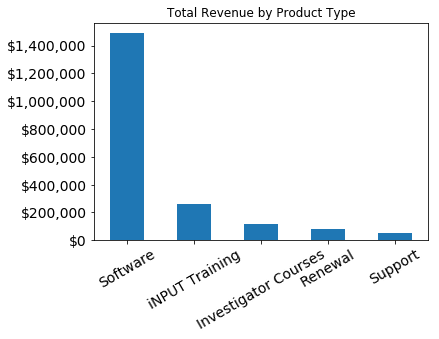

In [118]:
quant_by_type=open_opp.groupby('Product Family').sum()['Total Price'].sort_values(ascending=False) 
ax = quant_by_type.plot.bar(fontsize=14, title='Total Revenue by Product Type')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=30)
plt.ylabel('Total Price')
plt.ylabel('')
plt.xlabel('')
plt.show()

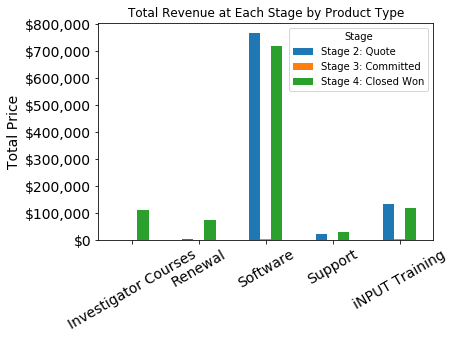

In [119]:
#'${:,.2f}'.format(open_opp['Price'])
groupbyproductstage = open_opp.groupby(['Product Family', 'Stage'])
#print groupbyproductstage['Total Price'].aggregate(np.sum)
groupbyproductstagesum = groupbyproductstage['Total Price'].aggregate(np.sum).unstack()
#print groupbyproductstagesum

ax = groupbyproductstagesum.plot(kind = 'bar', title = 'Total Revenue at Each Stage by Product Type', fontsize=14)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=30)
plt.ylabel('Total Price', fontsize=14)
plt.xlabel('')
plt.show()

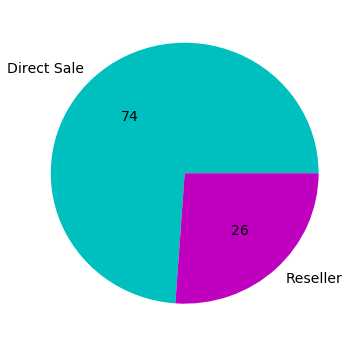

In [103]:
opportunities['reseller'] = 'Direct Sale'
opportunities.loc[(opportunities['Opportunity Name'].str.contains('Ocean')), ['reseller']] = 'Reseller'
open_opp = opportunities[opportunities['Stage']!='Closed Lost']
open_opp['reseller'].value_counts().plot(kind='pie', figsize=(6, 6), autopct='%.0f', fontsize=14, colors=['c','m'])
pylab.ylabel('')
plt.show()

In [121]:
#Subset the opportunities where customers already bought something.
closed_customers = opportunities[opportunities['Stage'] == 'Stage 4: Closed Won']
closed_customers = closed_customers[closed_customers['Past Close'] != 'NaN']

#Initialize new columns tracking the ones that need training vs. the ones that need license...

In [122]:
#Describe and plot training needs.

## 2. Progress through the Sales Pipeline

### a. *Time between stages*

In [123]:
#Supposed to be Avg time from stage to stage, if close date is in the past--what's up with the negatives?
opportunities['Difference'].describe()
#diff = opportunities[opportunities['Difference'] != 'NaN']
#plt.hist(diff['Difference']) 
#plt.show()

count    636.000000
mean     107.687107
std      134.853509
min        0.000000
25%       13.000000
50%       49.000000
75%      155.000000
max      588.000000
Name: Difference, dtype: float64

In [124]:
#Avg date from quote to final sale, if close date is in the past.
closed_customers['Difference'].describe()

count    533.000000
mean      88.716698
std      119.706347
min        0.000000
25%        9.000000
50%       39.000000
75%      122.000000
max      555.000000
Name: Difference, dtype: float64

## b. *Effect of training on movement through the pipeline*

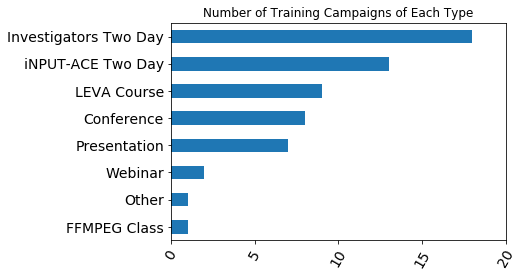

In [40]:
#How many campaigns by type
groupbycampaigncounts = campaigns.groupby('Campaign Type')['Campaign Name'].nunique().sort_values(ascending=True) 
groupbycampaigncounts.plot.barh(fontsize=14, title='Number of Training Campaigns of Each Type')
plt.xticks([0,5,10,15,20], rotation=60)
plt.ylabel('')
plt.ylabel('')
plt.xlabel('')
plt.show()



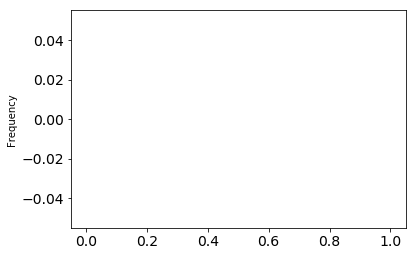

In [60]:
# How well attended are different types of training?
attendees = campaigns['Campaign Name'].value_counts()
campaignsbytype = campaigns.groupby('Campaign Type')
campaignsbytype['attendees'].plot(kind='hist', fontsize=14, bins=40)
plt.show()



In [ ]:
#Of agencies attending training campaigns and presentations, how many also purchase software/final training?
#How long after the campaign do they move forward in the sales pipeline? 
#By type of agency?

## 3. Relationship between Agency Demographics and Purchasing Behavior


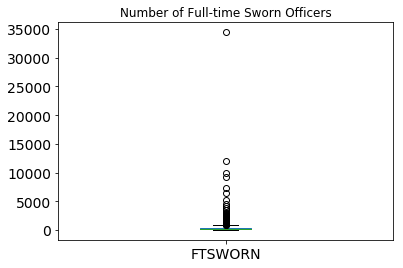

count      575.000000
mean       528.876522
std       1757.835931
min          1.000000
25%         79.000000
50%        161.000000
75%        407.000000
max      34454.000000
Name: FTSWORN, dtype: float64

In [95]:
#Create a dataframe for the subset of agencies in the BJS study that are in the iNPUT ACE contact list

bjs_sub = bjs.dropna(subset=['AGENCY ID'])
bjs_sub['FTSWORN'].plot(kind='box', title='Number of Full-time Sworn Officers', fontsize=14)
plt.ylabel('')
plt.ylabel('')
plt.xlabel('')
plt.show()
bjs_sub['FTSWORN'].describe()



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


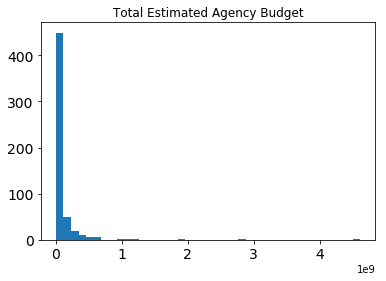

count    5.450000e+02
mean     9.243717e+07
std      2.799239e+08
min      1.080000e+05
25%      1.164595e+07
50%      2.480000e+07
75%      7.017400e+07
max      4.612690e+09
Name: BDGT_TTL, dtype: float64

In [98]:
bjs_sub['BDGT_TTL']=bjs_sub['BDGT_TTL'].astype(float)
bjs_sub['BDGT_TTL'].plot(kind='hist', title='Total Estimated Agency Budget', bins=40, fontsize=14)
plt.ylabel('')
plt.ylabel('')
plt.xlabel('')
plt.show()
bjs_sub['BDGT_TTL'].describe()

In [112]:
agencies2 = bjs_sub.set_index('AGENCY ID').join(opportunities.set_index('Agency ID'))
agencies2['spend_by_agency']=opportunities.groupby('Agency ID').sum()['Total Price'].sort_values(ascending=False) 
#agencies2['spend_by_agency']=agencies2['spend_by_agency'].astype(float)

to_corr = agencies2[['spend_by_agency','BDGT_TTL']]
to_corr.corr(method='pearson', min_periods=1)

#agencies2['BDGT_TTL'].corr(agencies2['spend_by_agency'])(method='pearson', min_periods=1)

,spend_by_agency,BDGT_TTL
spend_by_agency,1.000000,0.329242
BDGT_TTL,0.329242,1.000000
